# <center> **Clustering And Classification Of Seven Types Beans** </center>

#### **Student no :** 21627485 
####  **Student name :** Mustafa Kollu 

## **Table of Content**

[Purpose](#purpose)   
[Data Understanding](#data_understanding)   
[Data Preparation](#data_preparation)   
[Modeling for Clustering](#clusteringmodel)  
[Clustering results](#clustering)    
[Modeling for Classification](#classificationmodel)  
[Evaluation](#evaluation)  
[References](#references)   


In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/graphics-driver

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
import pyspark
from pyspark.sql import SQLContext
from pyspark import SparkContext


sc = SparkContext.getOrCreate()

Here we are installing the Spark environment.

## Purpose <a class="anchor" id="purpose"></a>

The aim of this project is to identify the types of beans using machine learning methods from the features created by digitizing various beans images. In this project, we will use two different machine learning methods. These are supervised learning and unsupervised learning. With these methods, it is to cluster and classify the data according to their types (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz, Sira).

## Data Understanding<a class="anchor" id="data_understanding"></a>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import MinMaxScaler,MinMaxScalerModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans,KMeansModel
from sklearn import metrics
from sklearn.metrics import classification_report,f1_score,accuracy_score,confusion_matrix,recall_score,precision_score
from pyspark.ml.classification import RandomForestClassifier

Firstly, We import the libraries we need to prepare our data.

In [6]:
sqlContext = SQLContext(sc)

In [7]:
OD = sqlContext.read.options(header=True,inferSchema=True).csv("/content/data.csv")

We are reading the chunk of data given in the form of a csv file.

In [8]:
type(OD)

pyspark.sql.dataframe.DataFrame

When we look at the type of dataframe, we see that it is a spark dataframe.

In [9]:
OD.show()

+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|28395|  610.291|    208.1781167|     173.888747| 1.197191424| 0.549812187|     28715|  190.1410973|0.763922518|0.988855999|0.958027126|0.913357755| 0.007331506| 0.003147289| 0.834222388| 0.998723889|SEKER|
|28734|  638.018|    200.5247957|    182.7344194| 1.097356461| 0.411785251|     29172|  191.2727505|0.783968133|0.984985603|0.887033637|0.953860842| 0.006978659| 0.00356362

In [10]:
OD.printSchema()

root
 |-- Area: integer (nullable = true)
 |-- Perimeter: double (nullable = true)
 |-- MajorAxisLength: double (nullable = true)
 |-- MinorAxisLength: double (nullable = true)
 |-- AspectRation: double (nullable = true)
 |-- Eccentricity: double (nullable = true)
 |-- ConvexArea: integer (nullable = true)
 |-- EquivDiameter: double (nullable = true)
 |-- Extent: double (nullable = true)
 |-- Solidity: double (nullable = true)
 |-- roundness: double (nullable = true)
 |-- Compactness: double (nullable = true)
 |-- ShapeFactor1: double (nullable = true)
 |-- ShapeFactor2: double (nullable = true)
 |-- ShapeFactor3: double (nullable = true)
 |-- ShapeFactor4: double (nullable = true)
 |-- Class: string (nullable = true)



In [11]:
OD.summary().show()

+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|summary|              Area|         Perimeter|  MajorAxisLength|  MinorAxisLength|       AspectRation|       Eccentricity|        ConvexArea|     EquivDiameter|              Extent|          Solidity|          roundness|        Compactness|        ShapeFactor1|        ShapeFactor2|      ShapeFactor3|        ShapeFactor4|   Class|
+-------+------------------+------------------+-----------------+-----------------+-------------------+-------------------+------------------+------------------+--------------------+------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+--------+
|

We see that the data consists of 13611 rows and 17 columns, excluding null. We find that all of our features are numeric but our label is an string. When we look at the details of the data, we see that some features contain very high numbers.

In [12]:
OD.select('Class').distinct().rdd.map(lambda r: r[0]).collect()

['CALI', 'SEKER', 'SIRA', 'HOROZ', 'BOMBAY', 'BARBUNYA', 'DERMASON']

In [13]:
OD.groupBy("Class").count().show()

+--------+-----+
|   Class|count|
+--------+-----+
|    CALI| 1630|
|   SEKER| 2027|
|    SIRA| 2636|
|   HOROZ| 1928|
|  BOMBAY|  522|
|BARBUNYA| 1322|
|DERMASON| 3546|
+--------+-----+



When we look at our target values, we see that the most "DERMASON" type beans.

In [14]:
OD.describe()

DataFrame[summary: string, Area: string, Perimeter: string, MajorAxisLength: string, MinorAxisLength: string, AspectRation: string, Eccentricity: string, ConvexArea: string, EquivDiameter: string, Extent: string, Solidity: string, roundness: string, Compactness: string, ShapeFactor1: string, ShapeFactor2: string, ShapeFactor3: string, ShapeFactor4: string, Class: string]

In [15]:
print((OD.count(), len(OD.columns)))

(13611, 17)


In [16]:
OD.filter('Class IS NULL').count()

0

In [17]:
OD.dropDuplicates()

DataFrame[Area: int, Perimeter: double, MajorAxisLength: double, MinorAxisLength: double, AspectRation: double, Eccentricity: double, ConvexArea: int, EquivDiameter: double, Extent: double, Solidity: double, roundness: double, Compactness: double, ShapeFactor1: double, ShapeFactor2: double, ShapeFactor3: double, ShapeFactor4: double, Class: string]

When we check whether there is repetitive data in our data, we see that 68 lines consist of repetitive data.

## Data Preparation<a class="anchor" id="data_preparation"></a>

We saw that there is no missing data and no null data in the data set. But we have to discard the duplicate data from our original data set.

In [18]:
OD=OD.dropDuplicates()

In [19]:
print((OD.count(), len(OD.columns)))

(13543, 17)


We remove the duplicate data from the data set from our original data set.

In [20]:
OD = OD.replace(to_replace={'CALI': '0', 'SEKER': '1','SIRA': '2', 'HOROZ': '3','BOMBAY': '4', 'BARBUNYA': '5','DERMASON': '6'}, subset=['Class'])
OD = OD.withColumn("Class",OD["Class"].cast('float'))

OD.show()
pandas_OD = OD.toPandas()

+------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|  Area|Perimeter|MajorAxisLength|MinorAxisLength|AspectRation|Eccentricity|ConvexArea|EquivDiameter|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+------+---------+---------------+---------------+------------+------------+----------+-------------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
| 36986|  693.771|    232.7137695|    202.5916367| 1.148683989| 0.492059713|     37350|  217.0069994|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|  1.0|
| 40587|   746.02|     262.969584|    196.7418707| 1.336622362| 0.663524591|     41053|  227.3256989|0.777528736| 0.98864882|0.916422776|0.864456244| 0.006479158| 0.002

Before putting our data set into a model, we should do feature selection. I decided this would be better with correlation. Correlation serves to show the relationship between the data in the data set. Before looking at correlation, we need to convert our data from objects to a dummy variable. So above we are making our target values as dummy variables.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


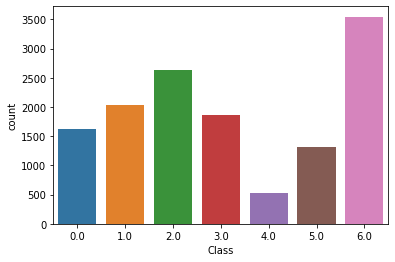

In [21]:
sns.countplot(pandas_OD.Class)

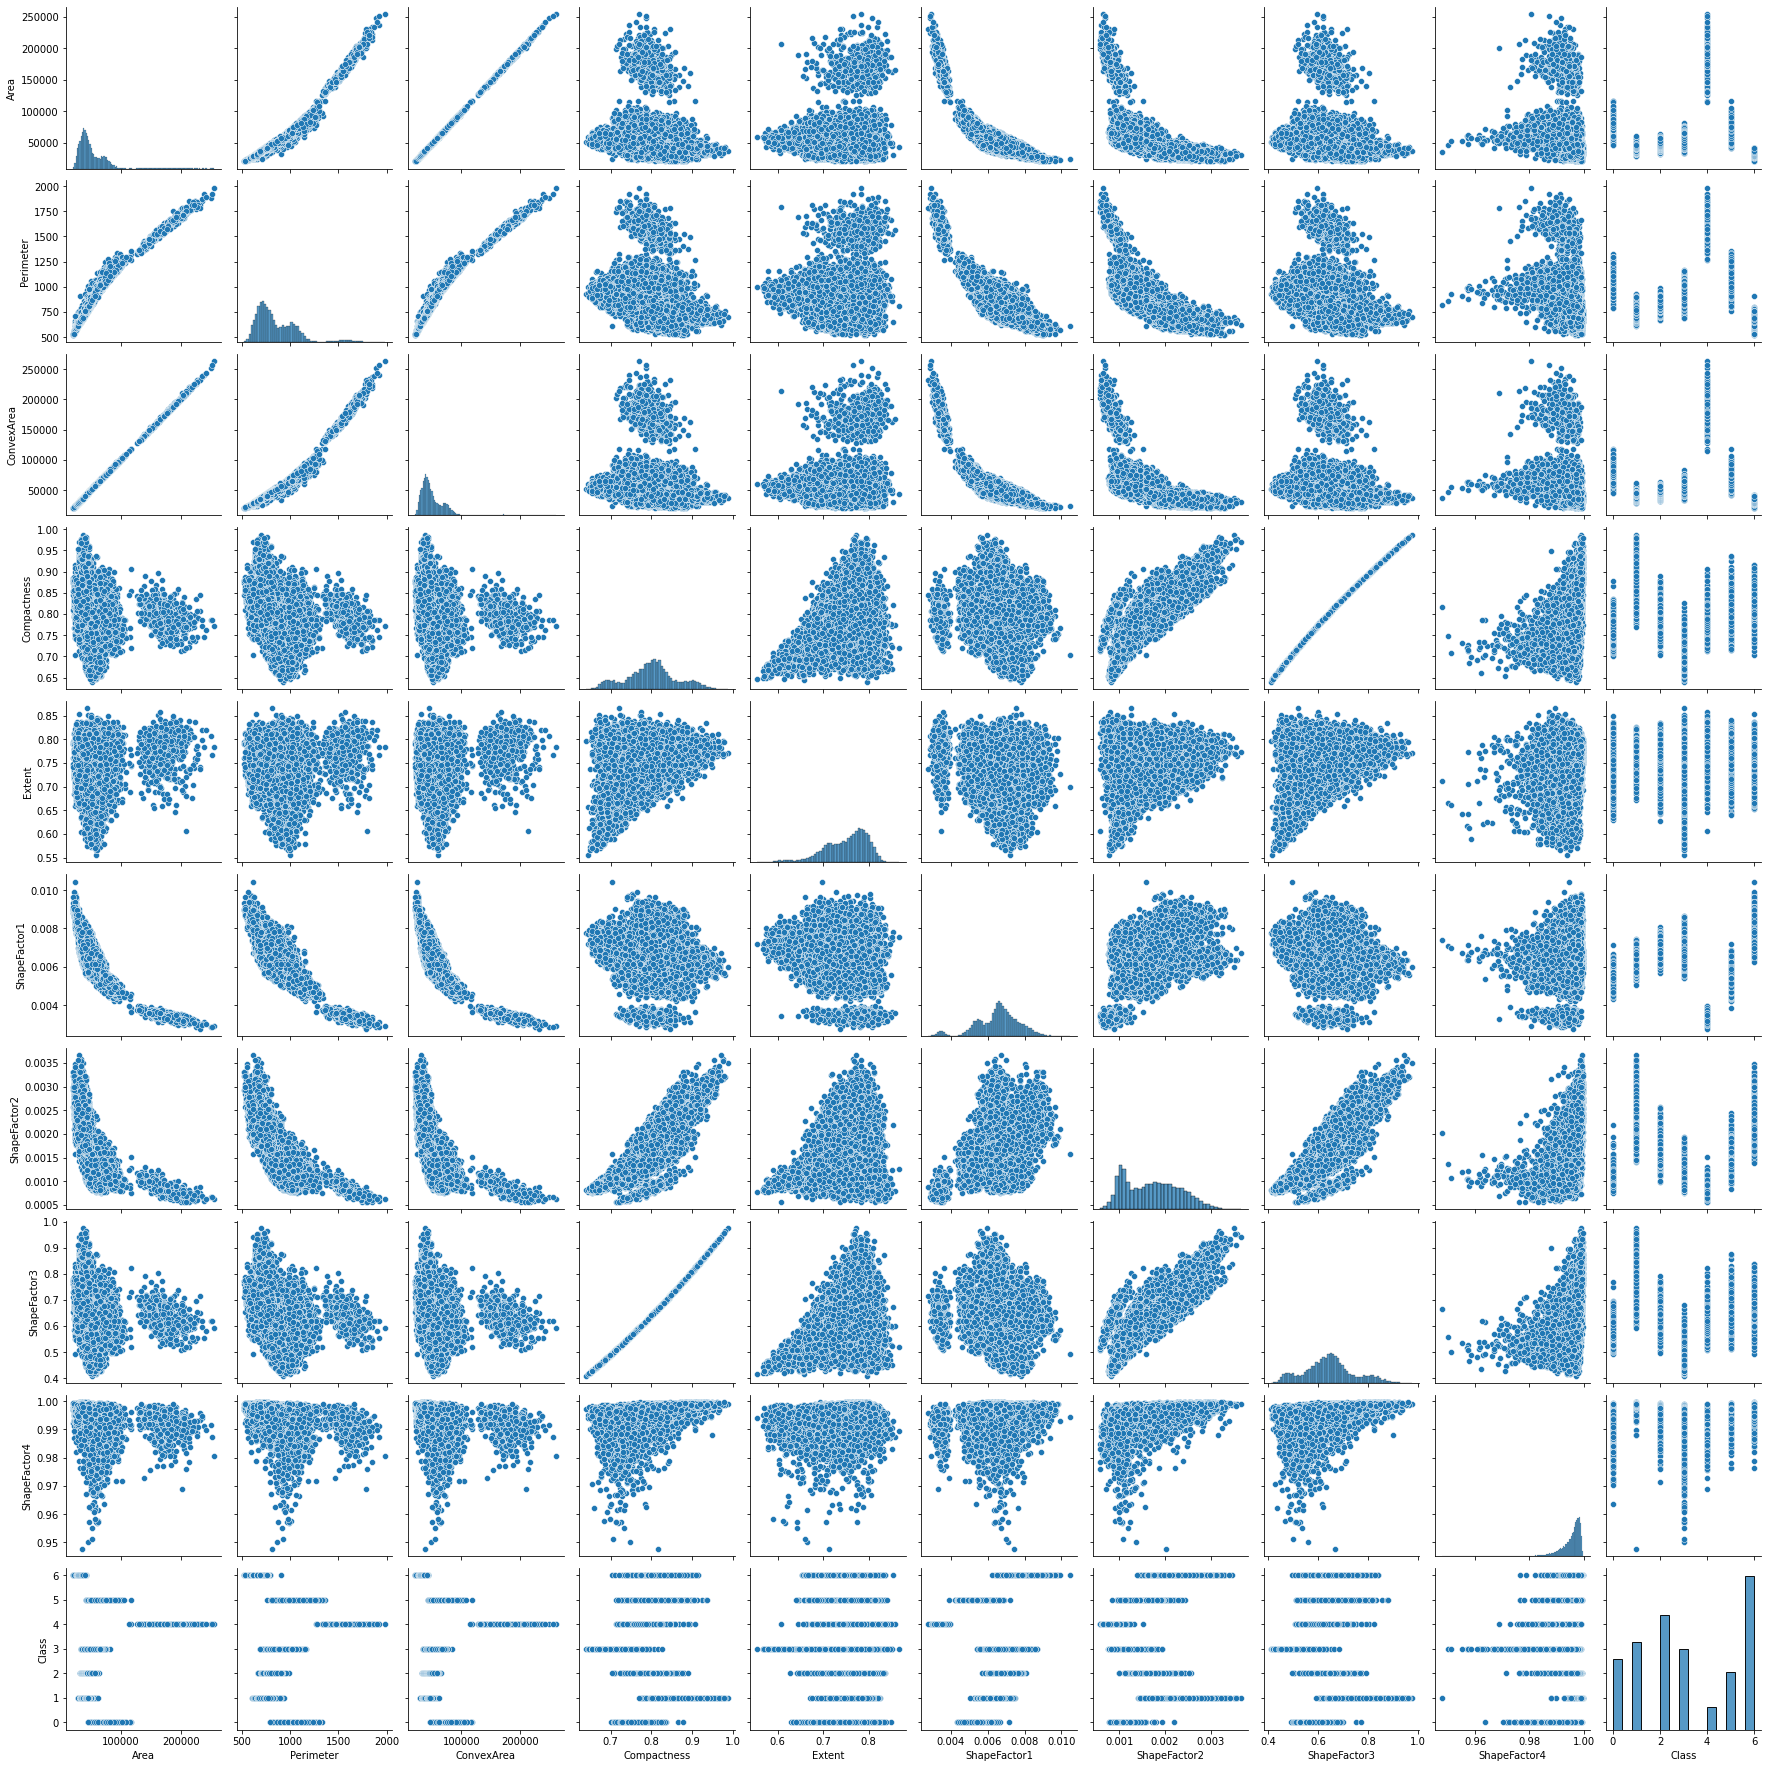

In [22]:
sns.pairplot(pandas_OD.loc[:,["Area","Perimeter","ConvexArea","Compactness","Extent","ShapeFactor1","ShapeFactor2","ShapeFactor3","ShapeFactor4","Class"]])

We are seeing bean pair plots with some features.

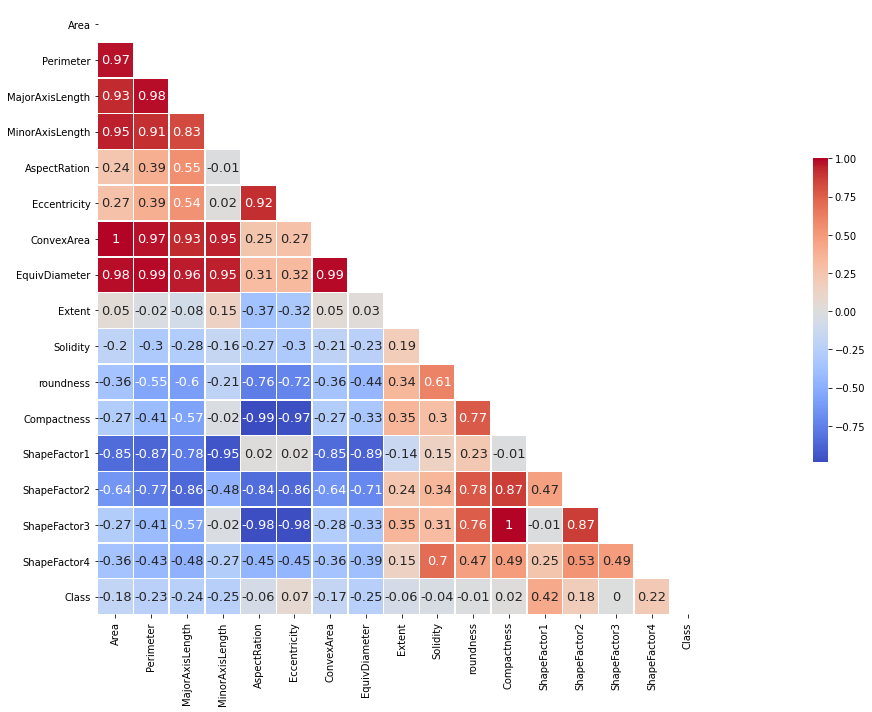

In [23]:
corr = pandas_OD.corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# Set figure size
f, ax = plt.subplots(figsize=(30, 10))


# Draw the heatmap
sns.heatmap(corr, mask=mask,cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True,annot_kws={'size':13})

plt.tight_layout()

Now that we can easily understand our correlation values, we can understand which data values are important to us.

In [24]:
columnsToDrops = ["Area", "Perimeter", "MajorAxisLength","MinorAxisLength","EquivDiameter","ConvexArea","Eccentricity",
         "AspectRation"]
OD=OD.drop(*columnsToDrops)

In [25]:
OD.show()

+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|  1.0|
|0.777528736| 0.98864882|0.916422776|0.864456244| 0.006479158| 0.002231878| 0.747284598| 0.998837305|  1.0|
|0.775780683|  0.9857805|0.875650377|0.814930403|  0.00638663| 0.001737535| 0.664111562| 0.996246456|  5.0|
|0.697560041|0.986510494|0.835432485|   0.799667| 0.005512379|  0.00139045| 0.639467311|  0.99721389|  5.0|
|0.810201547| 0.98267972|0.794251212|0.788608181| 0.005492874| 0.001310462| 0.621902863| 0.996692299|  5.0|
|0.755703443|0.979531194|0.735816765|0.780885972| 0.005545151| 0.001271873| 0.609782902| 0.997355314|  5.0|
|0.706233035|0.982434795|0.7

We discard unnecessary lines from the data set that we think would be to the detriment of the model. When we look at the information of the data set, we see that the number of rows and columns at the beginning has decreased. This is because we get rid of the noise before we put our data set into the model.

In [26]:
OD.show()

+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|  1.0|
|0.777528736| 0.98864882|0.916422776|0.864456244| 0.006479158| 0.002231878| 0.747284598| 0.998837305|  1.0|
|0.775780683|  0.9857805|0.875650377|0.814930403|  0.00638663| 0.001737535| 0.664111562| 0.996246456|  5.0|
|0.697560041|0.986510494|0.835432485|   0.799667| 0.005512379|  0.00139045| 0.639467311|  0.99721389|  5.0|
|0.810201547| 0.98267972|0.794251212|0.788608181| 0.005492874| 0.001310462| 0.621902863| 0.996692299|  5.0|
|0.755703443|0.979531194|0.735816765|0.780885972| 0.005545151| 0.001271873| 0.609782902| 0.997355314|  5.0|
|0.706233035|0.982434795|0.7

## Feature Outliers
We will look at the outliers of the features remaining in the data set and replace them with median. The purpose of doing this is that the outliers cause performance degradation in the model that works with a normalized data set. When we look at the features below, we see that there are also outliers except for "ShapeFactor2".

In [27]:
pandas_OD = OD.toPandas()

In [28]:
pandas_OD

Extent  Solidity  roundness  ...  ShapeFactor3  ShapeFactor4  Class
0      0.771748  0.990254   0.965639  ...      0.869568      0.998858    1.0
1      0.777529  0.988649   0.916423  ...      0.747285      0.998837    1.0
2      0.775781  0.985780   0.875650  ...      0.664112      0.996246    5.0
3      0.697560  0.986510   0.835432  ...      0.639467      0.997214    5.0
4      0.810202  0.982680   0.794251  ...      0.621903      0.996692    5.0
...         ...       ...        ...  ...           ...           ...    ...
13538  0.696359  0.991439   0.897802  ...      0.646019      0.997889    6.0
13539  0.770811  0.987807   0.885750  ...      0.600072      0.996123    6.0
13540  0.786424  0.989991   0.934883  ...      0.754713      0.998937    6.0
13541  0.768484  0.992877   0.946202  ...      0.689919      0.997992    6.0
13542  0.722240  0.987961   0.884293  ...      0.640768      0.994698    6.0

[13543 rows x 9 columns]

### Extent

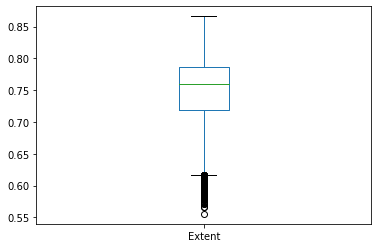

In [29]:
pandas_OD["Extent"].plot(kind="box")

In [30]:
mean = pandas_OD['Extent'].mean()
median = pandas_OD['Extent'].median()
std = pandas_OD['Extent'].std()
max = mean + (3 * std)
min =  mean - (2.7 * std)
pandas_OD.loc[pandas_OD.Extent < min, 'Extent'] = np.nan
pandas_OD.fillna(median,inplace=True)

### Solidity

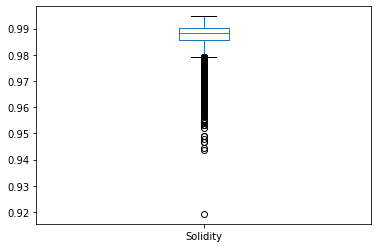

In [31]:
pandas_OD["Solidity"].plot(kind="box")

In [32]:
mean = pandas_OD['Solidity'].mean()
median = pandas_OD['Solidity'].median()
std = pandas_OD['Solidity'].std()
max = mean + (3 * std)
min =  mean - (2 * std)
pandas_OD.loc[pandas_OD.Solidity < min, 'Solidity'] = np.nan
pandas_OD.fillna(median,inplace=True)

### roundness

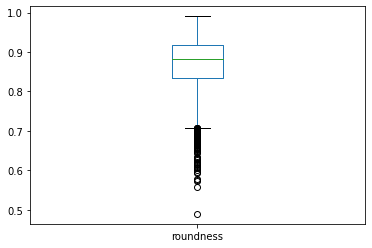

In [33]:
pandas_OD["roundness"].plot(kind="box")

In [34]:
mean = pandas_OD['roundness'].mean()
median = pandas_OD['roundness'].median()
std = pandas_OD['roundness'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.roundness < min, 'roundness'] = np.nan
pandas_OD.fillna(median,inplace=True)

In [35]:
mean = pandas_OD['roundness'].mean()
median = pandas_OD['roundness'].median()
std = pandas_OD['roundness'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.roundness >max, 'roundness'] = np.nan
pandas_OD.fillna(median,inplace=True)

### Compactness

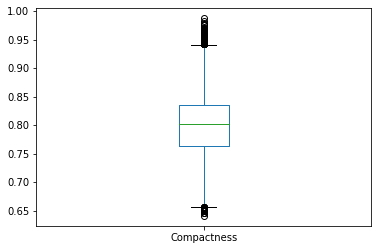

In [36]:
pandas_OD["Compactness"].plot(kind="box")

In [37]:
mean = pandas_OD['Compactness'].mean()
median = pandas_OD['Compactness'].median()
std = pandas_OD['Compactness'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.Compactness < min, 'Compactness'] = np.nan
pandas_OD.fillna(median,inplace=True)

In [38]:
mean = pandas_OD['Compactness'].mean()
median = pandas_OD['Compactness'].median()
std = pandas_OD['Compactness'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.Compactness > max, 'Compactness'] = np.nan
pandas_OD.fillna(median,inplace=True)

### ShapeFactor1

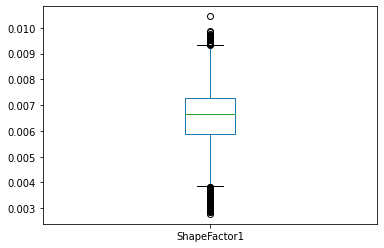

In [39]:
pandas_OD["ShapeFactor1"].plot(kind="box")

In [40]:
mean = pandas_OD['ShapeFactor1'].mean()
median = pandas_OD['ShapeFactor1'].median()
std = pandas_OD['ShapeFactor1'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.ShapeFactor1 < min, 'ShapeFactor1'] = np.nan
pandas_OD.fillna(median,inplace=True)

In [41]:
mean = pandas_OD['ShapeFactor1'].mean()
median = pandas_OD['ShapeFactor1'].median()
std = pandas_OD['ShapeFactor1'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.ShapeFactor1 >max, 'ShapeFactor1'] = np.nan
pandas_OD.fillna(median,inplace=True)

### ShapeFactor2

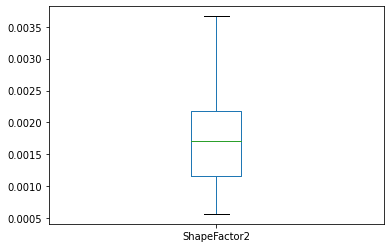

In [42]:
pandas_OD["ShapeFactor2"].plot(kind="box")

### ShapeFactor3

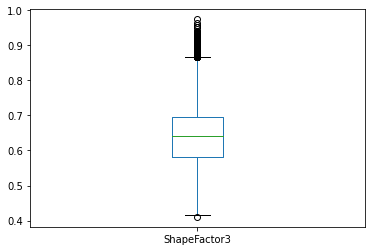

In [43]:
pandas_OD["ShapeFactor3"].plot(kind="box")

In [44]:
mean = pandas_OD['ShapeFactor3'].mean()
median = pandas_OD['ShapeFactor3'].median()
std = pandas_OD['ShapeFactor3'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.ShapeFactor3 > max, 'ShapeFactor3'] = np.nan
pandas_OD.fillna(median,inplace=True)

In [45]:
mean = pandas_OD['ShapeFactor3'].mean()
median = pandas_OD['ShapeFactor3'].median()
std = pandas_OD['ShapeFactor3'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.ShapeFactor3 <min, 'ShapeFactor3'] = np.nan
pandas_OD.fillna(median,inplace=True)

### ShapeFactor4

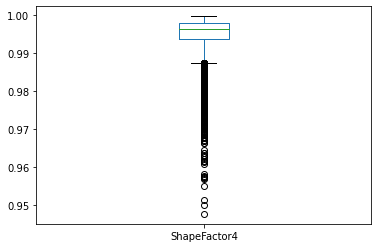

In [46]:
pandas_OD["ShapeFactor4"].plot(kind="box")

In [47]:
mean = pandas_OD['ShapeFactor4'].mean()
median = pandas_OD['ShapeFactor4'].median()
std = pandas_OD['ShapeFactor4'].std()
max = mean + (3 * std)
min =  mean - (3 * std)
pandas_OD.loc[pandas_OD.ShapeFactor4 < min, 'ShapeFactor4'] = np.nan
pandas_OD.fillna(median,inplace=True)

## Modeling for Clustering <a class="anchor" id="clusteringmodel"></a>

### Clustering with original data

In [48]:
OD = spark.createDataFrame(pandas_OD)
OD.show()

+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|  1.0|
|0.777528736| 0.98864882|0.916422776|0.864456244| 0.006479158| 0.002231878| 0.747284598| 0.998837305|  1.0|
|0.775780683|  0.9857805|0.875650377|0.814930403|  0.00638663| 0.001737535| 0.664111562| 0.996246456|  5.0|
|0.697560041|0.986510494|0.835432485|   0.799667| 0.005512379|  0.00139045| 0.639467311|  0.99721389|  5.0|
|0.810201547| 0.98267972|0.794251212|0.788608181| 0.005492874| 0.001310462| 0.621902863| 0.996692299|  5.0|
|0.755703443|0.979531194|0.735816765|0.780885972| 0.005545151| 0.001271873| 0.609782902| 0.997355314|  5.0|
|0.706233035|0.982434795|0.7

In [49]:
clusterOD = OD.drop("Class")
clusterODNorm = OD.drop("Class")
y = OD["Class"]

We divide our data set into two as feature and label.

In [50]:
OD.show()

+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|     Extent|   Solidity|  roundness|Compactness|ShapeFactor1|ShapeFactor2|ShapeFactor3|ShapeFactor4|Class|
+-----------+-----------+-----------+-----------+------------+------------+------------+------------+-----+
|0.771747522|0.990254351|0.965639328|0.932506056| 0.006291942|  0.00293475| 0.869567545| 0.998858317|  1.0|
|0.777528736| 0.98864882|0.916422776|0.864456244| 0.006479158| 0.002231878| 0.747284598| 0.998837305|  1.0|
|0.775780683|  0.9857805|0.875650377|0.814930403|  0.00638663| 0.001737535| 0.664111562| 0.996246456|  5.0|
|0.697560041|0.986510494|0.835432485|   0.799667| 0.005512379|  0.00139045| 0.639467311|  0.99721389|  5.0|
|0.810201547| 0.98267972|0.794251212|0.788608181| 0.005492874| 0.001310462| 0.621902863| 0.996692299|  5.0|
|0.755703443|0.979531194|0.735816765|0.780885972| 0.005545151| 0.001271873| 0.609782902| 0.997355314|  5.0|
|0.706233035|0.982434795|0.7

In [51]:
def dataAssembler(data):
  assembler = VectorAssembler(inputCols=list(set(data.columns)), outputCol="features")
  pipeline = Pipeline(stages=[assembler])
  scalerModel = pipeline.fit(data)
  scaledData = scalerModel.transform(data).select('features')
  scaledData.show(1,False)
  return scaledData

This function combines the features in the data set as a single column.

In [52]:
clusterOD = dataAssembler(clusterOD)

+------------------------------------------------------------------------------------------------+
|features                                                                                        |
+------------------------------------------------------------------------------------------------+
|[0.965639328,0.00293475,0.006291942,0.998858317,0.932506056,0.869567545,0.771747522,0.990254351]|
+------------------------------------------------------------------------------------------------+
only showing top 1 row



In [53]:
clusterOD.printSchema()

root
 |-- features: vector (nullable = true)



As you can see, features is the only column in the dataset.

In [54]:
kmeans = KMeans().setK(7).setSeed(1).setFeaturesCol("features")
modelCluster = kmeans.fit(clusterOD)

clusterODPred = modelCluster.transform(clusterOD).select("prediction")
clusterODPred.show()

+----------+
|prediction|
+----------+
|         2|
|         0|
|         5|
|         6|
|         4|
|         4|
|         4|
|         6|
|         1|
|         4|
|         4|
|         6|
|         0|
|         0|
|         5|
|         0|
|         5|
|         1|
|         3|
|         1|
+----------+
only showing top 20 rows



We train our original dataset with the k-means algorithm. We give the clustering number as 7.

In [55]:
centers = modelCluster.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.91437025 0.00212091 0.00712151 0.99691419 0.83399169 0.69514836
 0.75766738 0.98868796]
[0.82575535 0.00107542 0.00601746 0.99213654 0.73475797 0.54041403
 0.78219685 0.98674581]
[0.94769018 0.00261314 0.00637035 0.99832417 0.90278212 0.81545328
 0.77398191 0.99036668]
[0.79123598 0.00101526 0.00690026 0.99345867 0.69881116 0.4888255
 0.70215361 0.98675923]
[0.7846826  0.00145968 0.00544335 0.99558782 0.81115771 0.65861475
 0.74917993 0.9833068 ]
[0.88347005 0.00156557 0.00647943 0.9951073  0.79116332 0.62616686
 0.78824414 0.9882358 ]
[0.87173235 0.00157136 0.00667191 0.99490268 0.78484921 0.61632273
 0.70661128 0.98737247]


The center of our clusters seems to be above.

### Clustering with normalized data

In [56]:
def dataScaler(data):
  assembler = VectorAssembler(inputCols=list(set(data.columns)), outputCol="features")
  scaler = MinMaxScaler(inputCol="features", outputCol="featuresNorm")
  pipeline = Pipeline(stages=[assembler, scaler])
  scalerModel = pipeline.fit(data)
  scaledData = scalerModel.transform(data).select('featuresNorm',"features")
  scaledData.show(1,False)
  return scaledData

In this function I normalized my data using MinMaxScaler. Because we use the MinMaxScaler method to normalize values and reduce dominance. MinMax Scaling is a situation in which data takes values between 0 and 1. Also, this function combines the features in the data set as a single column.

In [57]:
clusterODNorm = dataScaler(clusterODNorm)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|featuresNorm                                                                                                                                           |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.9151102431287027,0.7645055167967781,0.4637264298365963,0.9505560719006563,0.856011331103787,0.869578614179404,0.6193783055176495,0.7369853302459269]|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+
only showing top 1 row



In [58]:
clusterODNorm.printSchema()

root
 |-- featuresNorm: vector (nullable = true)



As you can see, features is the only column in the dataset.

In [59]:
kmeansNorm = KMeans().setK(7).setSeed(1).setFeaturesCol("featuresNorm")
modelClusterNorm = kmeansNorm.fit(clusterODNorm)

clusterODPredNorm = modelClusterNorm.transform(clusterODNorm).select("prediction")
clusterODPredNorm.show()

+----------+
|prediction|
+----------+
|         0|
|         0|
|         5|
|         6|
|         6|
|         6|
|         6|
|         6|
|         2|
|         6|
|         6|
|         6|
|         6|
|         2|
|         2|
|         2|
|         2|
|         1|
|         4|
|         1|
+----------+
only showing top 20 rows



We train our normalized dataset with the k-means algorithm. We give the clustering number as 7.

In [60]:
centers = modelClusterNorm.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.85938617 0.65446147 0.48328572 0.92330596 0.75798046 0.75272136
 0.62287628 0.75434794]
[0.470397   0.18809504 0.38995094 0.34291313 0.33125049 0.3001325
 0.52557715 0.36017055]
[0.55662942 0.18722523 0.31274191 0.69353843 0.38985939 0.35751712
 0.65500328 0.67086064]
[0.65315563 0.40605997 0.59711535 0.79692483 0.4682087  0.43654148
 0.37821401 0.6095407 ]
[0.33877456 0.15191972 0.55855274 0.70292694 0.17787497 0.15520855
 0.41496703 0.57297346]
[0.72673899 0.4870534  0.63039534 0.84720335 0.52623699 0.49729045
 0.63864576 0.65329201]
[0.35761905 0.28751229 0.3404165  0.78786648 0.49552777 0.46624559
 0.5277359  0.30200365]


The center of our clusters seems to be above.

## Clustering results<a class="anchor" id="clustering"></a>

### Clustering results with original data

In [61]:
pandasOD = OD.toPandas()
clusterODPred = clusterODPred.toPandas()

In [62]:
pandasOD["Predict"] = clusterODPred["prediction"]
pandasOD

Extent  Solidity  roundness  ...  ShapeFactor4  Class  Predict
0      0.771748  0.990254   0.965639  ...      0.998858    1.0        2
1      0.777529  0.988649   0.916423  ...      0.998837    1.0        0
2      0.775781  0.985780   0.875650  ...      0.996246    5.0        5
3      0.697560  0.986510   0.835432  ...      0.997214    5.0        6
4      0.810202  0.982680   0.794251  ...      0.996692    5.0        4
...         ...       ...        ...  ...           ...    ...      ...
13538  0.696359  0.991439   0.897802  ...      0.997889    6.0        6
13539  0.770811  0.987807   0.885750  ...      0.996123    6.0        5
13540  0.786424  0.989991   0.934883  ...      0.998937    6.0        2
13541  0.768484  0.992877   0.946202  ...      0.997992    6.0        0
13542  0.722240  0.987961   0.884293  ...      0.994698    6.0        6

[13543 rows x 10 columns]

In [63]:
clusterODPred

prediction
0               2
1               0
2               5
3               6
4               4
...           ...
13538           6
13539           5
13540           2
13541           0
13542           6

[13543 rows x 1 columns]

In [64]:
def grapher(pandasData):
  f, axes = plt.subplots(4, 2,figsize=(20,20))
  sns.scatterplot(x="Extent", y="Solidity",
                hue="Predict", style="Predict", data=pandasData,ax=axes[0][0])

  sns.scatterplot(x="roundness", y="Compactness",
                     hue="Class", style="Class", data=pandasData,ax=axes[0][1])


  sns.scatterplot(x="ShapeFactor1", y="ShapeFactor2",
                hue="Predict", style="Predict", data=pandasData,ax=axes[1][0])

  sns.scatterplot(x="ShapeFactor3", y="ShapeFactor4",
                     hue="Class", style="Class", data=pandasData,ax=axes[1][1])
  

  sns.scatterplot(x="Extent", y="ShapeFactor2",
                hue="Predict", style="Predict", data=pandasData,ax=axes[2][0])

  sns.scatterplot(x="Solidity", y="ShapeFactor1",
                     hue="Class", style="Class", data=pandasData,ax=axes[2][1])


  sns.scatterplot(x="roundness", y="ShapeFactor3",
                hue="Predict", style="Predict", data=pandasData,ax=axes[3][0])

  sns.scatterplot(x="Compactness", y="ShapeFactor4",
                     hue="Class", style="Class", data=pandasData,ax=axes[3][1])


  f.tight_layout()

  plt.show()

This function allows us to use graph to compare the clusters we estimate and the original cluster results.

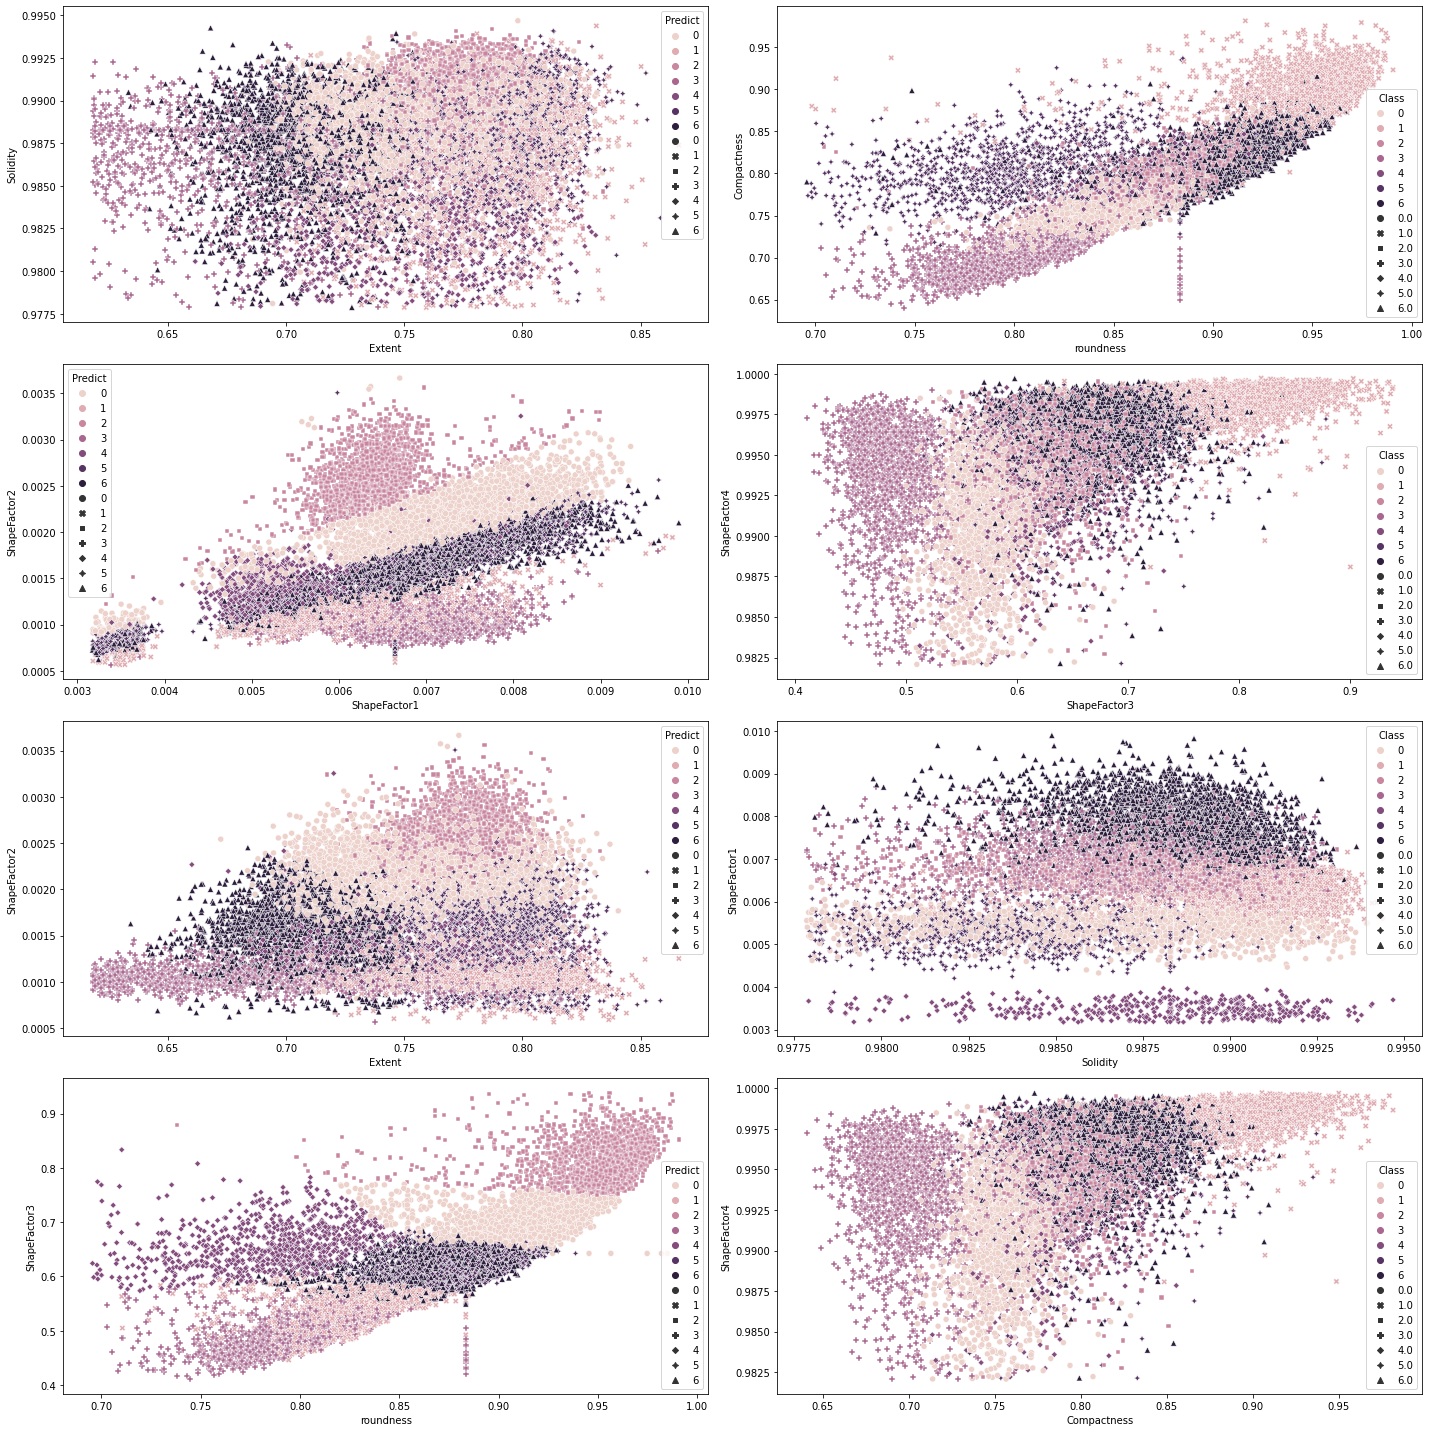

In [65]:
grapher(pandasOD)

Above, we see the graph of the clusters we predicted and the original cluster results.

### Clustering results with normalized data

In [66]:
pandasODNorm = OD.toPandas()
clusterODPredNorm = clusterODPredNorm.toPandas()

In [67]:
pandasODNorm["Predict"] = clusterODPredNorm["prediction"]
pandasODNorm

Extent  Solidity  roundness  ...  ShapeFactor4  Class  Predict
0      0.771748  0.990254   0.965639  ...      0.998858    1.0        0
1      0.777529  0.988649   0.916423  ...      0.998837    1.0        0
2      0.775781  0.985780   0.875650  ...      0.996246    5.0        5
3      0.697560  0.986510   0.835432  ...      0.997214    5.0        6
4      0.810202  0.982680   0.794251  ...      0.996692    5.0        6
...         ...       ...        ...  ...           ...    ...      ...
13538  0.696359  0.991439   0.897802  ...      0.997889    6.0        3
13539  0.770811  0.987807   0.885750  ...      0.996123    6.0        5
13540  0.786424  0.989991   0.934883  ...      0.998937    6.0        0
13541  0.768484  0.992877   0.946202  ...      0.997992    6.0        5
13542  0.722240  0.987961   0.884293  ...      0.994698    6.0        3

[13543 rows x 10 columns]

In [68]:
clusterODPredNorm

prediction
0               0
1               0
2               5
3               6
4               6
...           ...
13538           3
13539           5
13540           0
13541           5
13542           3

[13543 rows x 1 columns]

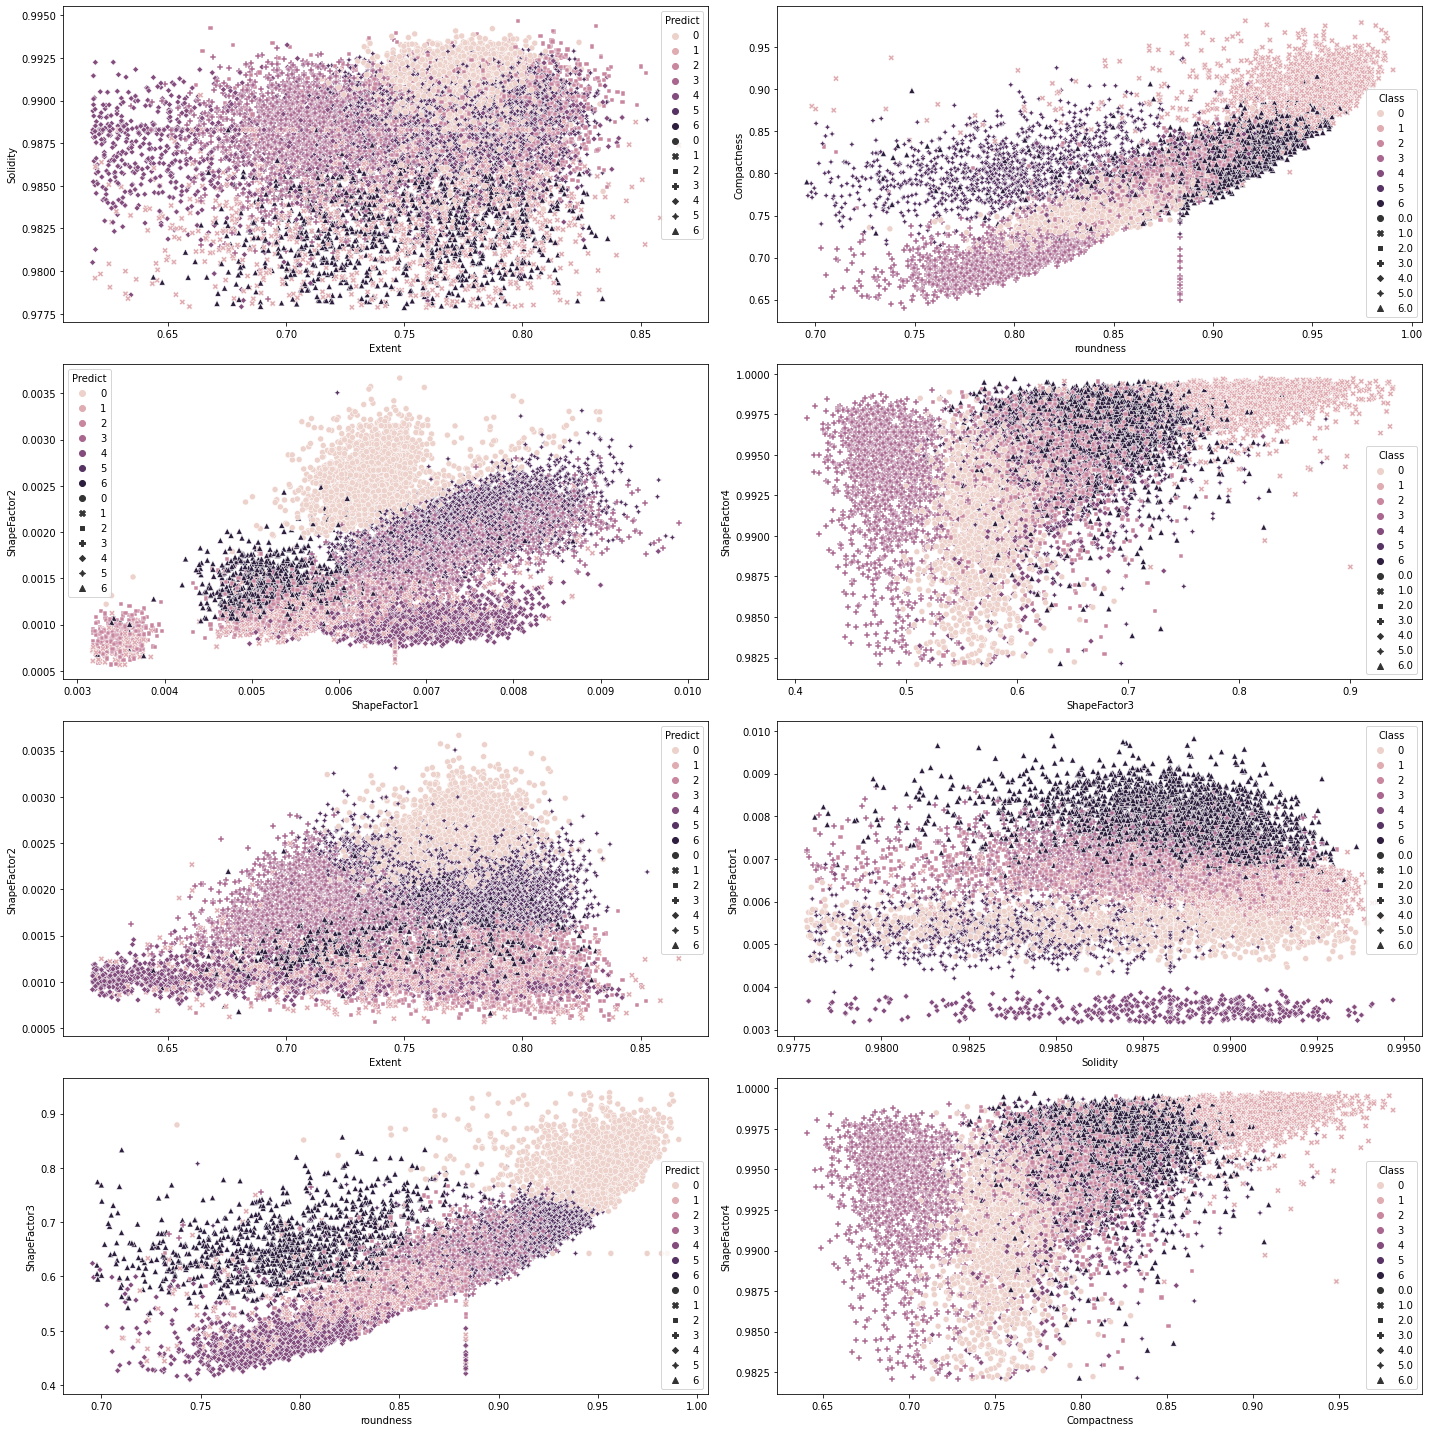

In [69]:
grapher(pandasODNorm)


Above, we see the graph of the clusters we predicted and the original cluster results.

### Evaluation with original data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


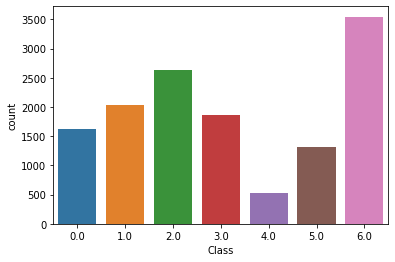

In [70]:
sns.countplot(pandasOD.Class)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


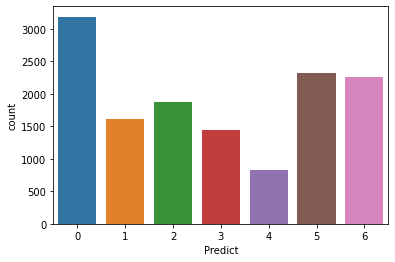

In [71]:
sns.countplot(pandasOD.Predict)

Above, you can see the label data we estimate and the actual label data.

In [72]:
metrics.silhouette_score(pandasOD,pandasOD.Predict)

0.3083314469768512

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

### Evaluation with normalized data

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


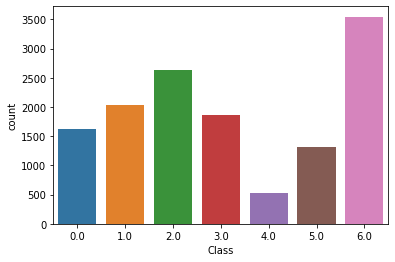

In [73]:
sns.countplot(pandasODNorm.Class)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


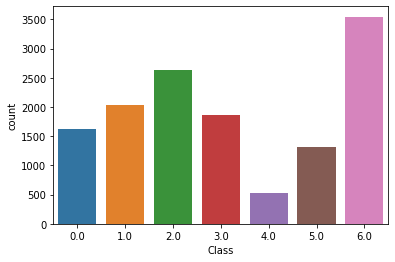

In [74]:
sns.countplot(pandasODNorm.Class)

Above, you can see the label data we estimate and the actual label data.

In [75]:
metrics.silhouette_score(pandasODNorm,pandasODNorm.Predict)

0.2604689629578559

Silhouette refers to a method of interpretation and validation of consistency within clusters of data. The technique provides a succinct graphical representation of how well each object has been classified.

## Modeling for Classification <a class="anchor" id="classificationmodel"></a>

I decided to use the Random Forest Trees algorithm. Because the Random Forest Trees algorithm is a group learning method for both classification and regression problems. Separates data and creates multiple decision trees. The result is a combination of these decision trees. Also the reason I chose Random Forest Trees is because of a group method. Therefore, you are less likely to face an overfitting problem.

In [76]:
def dataAssembler(data):
  assembler = VectorAssembler(inputCols=list(set(data.columns)-{"Class"}), outputCol="features")
  pipeline = Pipeline(stages=[assembler])
  scalerModel = pipeline.fit(data)
  scaledData = scalerModel.transform(data).select('features',"Class")
  scaledData.show(1,False)
  return scaledData

This function combines the features in the data set as a single column.

In [77]:
def dataScaler(data):
  assembler = VectorAssembler(inputCols=list(set(data.columns)-{"Class"}), outputCol="features")
  scaler = MinMaxScaler(inputCol="features", outputCol="featuresNorm")
  pipeline = Pipeline(stages=[assembler, scaler])
  scalerModel = pipeline.fit(data)
  scaledData = scalerModel.transform(data).select('featuresNorm',"Class")
  scaledData.show(1,False)
  return scaledData

In this function I normalized my data using MinMaxScaler. Because we use the MinMaxScaler method to normalize values and reduce dominance. MinMax Scaling is a situation in which data takes values between 0 and 1. Also, this function combines the features in the data set as a single column.

### Classification with original data

In [78]:
classificationOD = OD

In [79]:
classificationOD = dataAssembler(classificationOD)

+------------------------------------------------------------------------------------------------+-----+
|features                                                                                        |Class|
+------------------------------------------------------------------------------------------------+-----+
|[0.965639328,0.00293475,0.006291942,0.998858317,0.932506056,0.869567545,0.771747522,0.990254351]|1.0  |
+------------------------------------------------------------------------------------------------+-----+
only showing top 1 row



As you can see, features and Class column in the dataset.

In [80]:
(trainData, testData) = classificationOD.randomSplit([0.7, 0.3])

In this function, I split my data with a 30% test - 70% training rate.

In [81]:
forest = RandomForestClassifier(featuresCol='features', labelCol='Class')

Here I am creating an object from the RandomForestClassifier algorithm.

In [82]:
forestT = forest.fit(trainData)
predictData = forestT.transform(testData)
predictData.show(5,False)

+-------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+----------+
|features                                                                                         |Class|rawPrediction                                                                                                                            |probability                                                                                                                                    |prediction|
+-------------------------------------------------------------------------------------------------+-----+-------------------------------------------------------------------------------------------------

We train our model with the train set obtained from our original data set. And we transform our model with the test set obtained from our original data set.

In [83]:
predictDataPandas = predictData.toPandas()
predictDataPandas

features  ...  prediction
0     [0.700101803, 0.002192305, 0.006017554, 0.9974...  ...         1.0
1     [0.704228007, 0.001914396, 0.006470343, 0.9965...  ...         2.0
2     [0.710238015, 0.00197218, 0.006893262, 0.99075...  ...         2.0
3     [0.711158427, 0.000882805, 0.006054921, 0.9870...  ...         3.0
4     [0.71149046, 0.001337528, 0.005403301, 0.99702...  ...         5.0
...                                                 ...  ...         ...
4049  [0.977701475, 0.002904403, 0.006002403, 0.9982...  ...         1.0
4050  [0.9782764, 0.002909689, 0.006442199, 0.998715...  ...         1.0
4051  [0.978895816, 0.00268245, 0.006235261, 0.99742...  ...         1.0
4052  [0.983256019, 0.00284649, 0.006425174, 0.99915...  ...         1.0
4053  [0.986684731, 0.003144127, 0.006526545, 0.9990...  ...         1.0

[4054 rows x 5 columns]

### Classification with normalized data

In [84]:
classificationODNorm = OD

In [85]:
classificationODNorm = dataScaler(classificationODNorm)

+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|featuresNorm                                                                                                                                           |Class|
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.9151102431287027,0.7645055167967781,0.4637264298365963,0.9505560719006563,0.856011331103787,0.869578614179404,0.6193783055176495,0.7369853302459269]|1.0  |
+-------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
only showing top 1 row



As you can see, features and Class column in the dataset.

In [86]:
(trainNormData, testNormData) = classificationODNorm.randomSplit([0.7, 0.3])

In this function, I split my data with a 30% test - 70% training rate.

In [87]:
forestNorm = RandomForestClassifier(featuresCol='featuresNorm', labelCol='Class')

Here I am creating an object from the RandomForestClassifier algorithm.

In [88]:
forestNormT = forestNorm.fit(trainNormData)
predictDataNorm = forestNormT.transform(testNormData)
predictDataNorm.show(5,False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+-----------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|featuresNorm                                                                                                                                                  |Class|rawPrediction                                                                                                                            |probability                                                                                                                                     |prediction|
+-----------------------------------------------------------------------------

We train our model with the train set obtained from our original data set. And we transform our model with the test set obtained from our original data set.

In [89]:
predictDataNormPandas = predictDataNorm.toPandas()
predictDataNormPandas

featuresNorm  ...  prediction
0     [0.024604496248324597, 0.17187322122688864, 0....  ...         3.0
1     [0.029097319301981783, 0.435444302653216, 0.49...  ...         2.0
2     [0.041236278994457774, 0.23639070266637385, 0....  ...         5.0
3     [0.0497865435134469, 0.20258526581662878, 0.36...  ...         5.0
4     [0.049805327258562015, 0.659231173344453, 0.43...  ...         1.0
...                                                 ...  ...         ...
4110  [0.9583929437054953, 0.7123093598658155, 0.453...  ...         1.0
4111  [0.9599768553891658, 0.7655629848139337, 0.514...  ...         1.0
4112  [0.9634864195454744, 0.7698093042350642, 0.529...  ...         1.0
4113  [0.9663303707460501, 0.6675161240491576, 0.471...  ...         1.0
4114  [0.9670656652275531, 0.8747734054694863, 0.521...  ...         1.0

[4115 rows x 5 columns]

## Evaluation<a class="anchor" id="evaluation"></a>

### Evaluation with original data

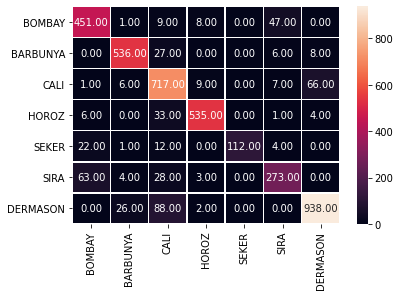

In [90]:
cm = confusion_matrix(predictDataPandas.Class, predictDataPandas.prediction)
sns.heatmap(
    data=cm,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    xticklabels=["BOMBAY", "BARBUNYA","CALI","HOROZ","SEKER","SIRA","DERMASON"],
    yticklabels=["BOMBAY", "BARBUNYA","CALI","HOROZ","SEKER","SIRA","DERMASON"]
)

fig = plt.gcf()

plt.show()

We now give test data to the model that we trained from our original data set, and we look at which one is measured correctly and which is wrong. We use the confusion matrix method for this and the heatmap method to visualize it.

In [91]:
print(classification_report(predictDataPandas.Class, predictDataPandas.prediction))

              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       516
         1.0       0.93      0.93      0.93       577
         2.0       0.78      0.89      0.83       806
         3.0       0.96      0.92      0.94       579
         4.0       1.00      0.74      0.85       151
         5.0       0.81      0.74      0.77       371
         6.0       0.92      0.89      0.91      1054

    accuracy                           0.88      4054
   macro avg       0.89      0.85      0.87      4054
weighted avg       0.88      0.88      0.88      4054



Above, we see the results obtained with the test data of the model created from the original data set. When we look at the accuracy rate, we see that we got a value of 88%. We can also see other test methods we use for accuracy.

### Evaluation with normalized data

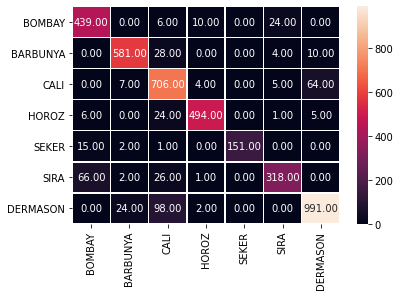

In [92]:
cm = confusion_matrix(predictDataNormPandas.Class, predictDataNormPandas.prediction)
sns.heatmap(
    data=cm,
    annot=True,
    fmt='.2f',
    linewidths=.5,
    xticklabels=["BOMBAY", "BARBUNYA","CALI","HOROZ","SEKER","SIRA","DERMASON"],
    yticklabels=["BOMBAY", "BARBUNYA","CALI","HOROZ","SEKER","SIRA","DERMASON"]
)

fig = plt.gcf()

plt.show()

We now give test data to the model that we trained from our original data set, and we look at which one is measured correctly and which is wrong. We use the confusion matrix method for this and the heatmap method to visualize it.

In [93]:
print(classification_report(predictDataNormPandas.Class, predictDataNormPandas.prediction))

              precision    recall  f1-score   support

         0.0       0.83      0.92      0.87       479
         1.0       0.94      0.93      0.94       623
         2.0       0.79      0.90      0.84       786
         3.0       0.97      0.93      0.95       530
         4.0       1.00      0.89      0.94       169
         5.0       0.90      0.77      0.83       413
         6.0       0.93      0.89      0.91      1115

    accuracy                           0.89      4115
   macro avg       0.91      0.89      0.90      4115
weighted avg       0.90      0.89      0.89      4115



Above, we see the results obtained with the test data of the model created from the original data set. When we look at the accuracy rate, we see that we got a value of 89%. We can also see other test methods we use for accuracy.

## References<a class="anchor" id="references"></a>

1. https://spark.apache.org

2. https://www.datacamp.com/community/tutorials/apache-spark-tutorial-machine-learning

3. https://towardsdatascience.com/pyspark-in-google-colab-6821c2faf41c

4. https://github.com/ahmetalkilinc/DataScienceTutorials

5. http://yunus.hacettepe.edu.tr/~akal/BBM467/ (Lecture Notes)


**Disclaimer!** <font color='grey'>This notebook was prepared by Mustafa Kollu as an assigment for the *BBM469 - Data Intensive Applications Laboratory* class. The notebook is available for educational purposes only. There is no guarantee on the correctness of the content provided as it is a student work.

If you think there is any copyright violation, please let us [know](https://forms.gle/BNNRB2kR8ZHVEREq8). 
</font>